In [ ]:
#imports and related libraries
!pip install pyreadstat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from joblib import dump

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 7.7 MB/s eta 0:00:00


# **Load and Inspect Data**
We begin by loading data from the 2014 Zimbabwe MICS survey, conducted by UNICEF.

The .sav files include:



*   hh.sav: household-level data, containing variables like wealth index (windex5),region (HH7), and urban/rural status (HH6).
*   hl.sav: household member data, including age (HL7), sex (HL4), and education level (ED4A).

These two datasets will be merged to create a modeling-ready table.

In [ ]:
hh = pd.read_spss("hh.sav")
hl = pd.read_spss("hl.sav")
df = pd.merge(hl, hh[["HH1", "HH2", "HH6", "HH7", "windex5"]], on=["HH1", "HH2"], how="left")
df = df.rename(columns={
    "HH6_y": "HH6",
    "HH7_y": "HH7",
    "windex5_y": "windex5"
})

# **Clean and Merge Datasets**
Next I filtered the dataset to include school-aged individuals (age ≥ 10) and those with valid education attainment data.
Then I merged the hh and hl datasets using household IDs (HH1, HH2) to join each individual with their household-level characteristics like wealth and location.

I also created our target variable, where:


*   1 = completed secondary education
*   0 = did not complete secondary education

In [ ]:
# Convert age to numeric
df["HL7"] = pd.to_numeric(df["HL7"], errors="coerce")
df = df[df["HL7"] >= 10]  # HL7 = Age
df = df[df["ED4A"].notna()]  # ED4A = Highest level of education attained
df["target"] = df["ED4A"].apply(lambda x: 1 if "Secondary" in str(x) else 0)
# 4. Select features of interest
features = ["HL7", "HL4", "HH6", "HH7", "windex5"]  # Age, Sex, Urban/Rural, Region, Wealth Index
df = df[features + ["target"]]



# **Encode Categorical Variables**
Several input features are categorical, such as:

* Sex (Male/Female)

* Urban/Rural status

* Region

* Wealth Quintile (e.g., Poorest, Richest)

We use a mix of manual mappings (for ordered categories) and label encoding (for nominal ones like region) to convert all variables into numeric format for modeling.

**Note:** Nearly all individuals with complete data are female. As such, sex is included structurally but may not significantly influence the model.

In [ ]:
# Manual encoding for ordered categorical variables

# a. Sex: Male = 0, Female = 1
df["HL4"] = df["HL4"].map({"Male": 0, "Female": 1})

# b. Urban/Rural: Rural = 0, Urban = 1
df["HH6"] = df["HH6"].map({"Rural": 0, "Urban": 1})

# c .Clean and standardize values before mapping
df["windex5"] = df["windex5"].astype(str).str.strip().str.title()

# Apply map
wealth_map = {
    "Poorest": 0,
    "Second": 1,
    "Middle": 2,
    "Fourth": 3,
    "Richest": 4
}
df["windex5"] = df["windex5"].map(wealth_map)


# d. Nominal encoding for Region using LabelEncoder

region_encoder = LabelEncoder()
df["HH7"] = region_encoder.fit_transform(df["HH7"].astype(str))



# **Visualize Data Correlations**
Next I created a correlation matrix heatmap to understand relationships between variables and the target (secondary school completion).
This helps identify potentially redundant or weakly relevant features and guides us in refining our model.

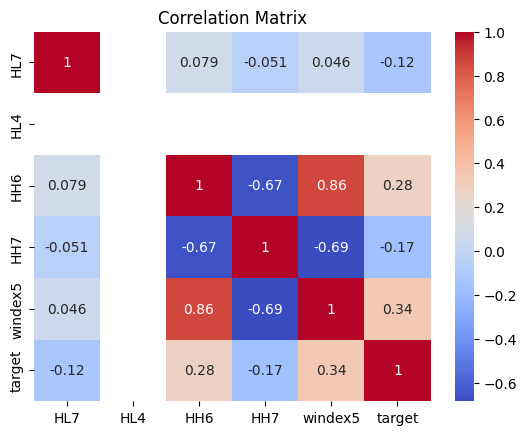

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()




# **Train and Compare Models**
I then split the data into training and testing sets, standardized features, and trained three models:

* Linear Regression

* Decision Tree Regressor

* Random Forest Regressor

I proceeded then to evaluate each using Mean Squared Error (MSE) on the test set. The model with the lowest MSE was  selected for deployment.



In [ ]:
# Feature and target split
X = df.drop(columns=["target"])
y = df["target"]

In [ ]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# 10. Linear regression using gradient descent
sgd = SGDRegressor(
    max_iter=1000,
    learning_rate='constant',  # Use a fixed learning rate
    eta0=0.001,                # Small step size to prevent exploding weights
    tol=1e-3,
    random_state=42
)
train_losses, test_losses = [], []

for i in range(1, 100):
    sgd.partial_fit(X_train, y_train)
    train_loss = mean_squared_error(y_train, sgd.predict(X_train))
    test_loss = mean_squared_error(y_test, sgd.predict(X_test))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

In [ ]:
# checking that predicted values are realistic
preds = sgd.predict(X_train)
print(f"Prediction range: {preds.min()} to {preds.max()}")

Prediction range: 0.40603303954746495 to 0.9674328659290277


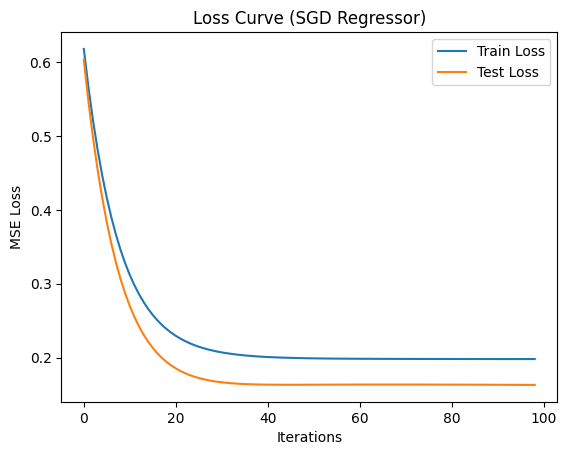

In [ ]:
# Plot loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (SGD Regressor)")
plt.legend()
plt.show()


This next plot shows the model’s predicted probability of secondary school completion across standardized wealth levels. The upward slope of the red line confirms the role of structural poverty in limiting educational outcomes, directly supporting the mission of this project.

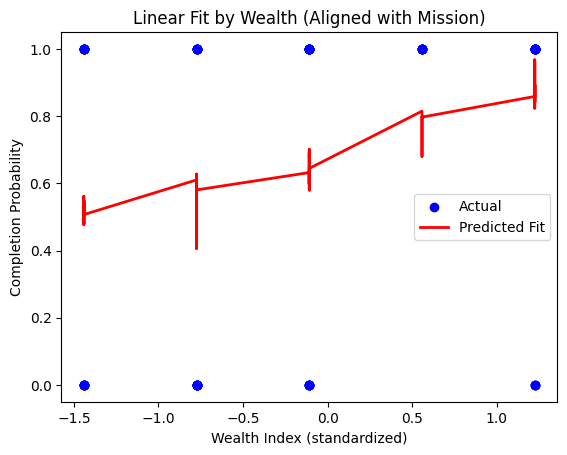

In [ ]:
#  Get wealth column from standardized features
x_wealth = X_train[:, 4]
y_actual = y_train
y_pred = sgd.predict(X_train)
sorted_idx = x_wealth.argsort()
x_sorted = x_wealth[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
plt.scatter(x_wealth, y_actual, color='blue', label='Actual')
plt.plot(x_sorted, y_pred_sorted, color='red', label='Predicted Fit', linewidth=2)
plt.xlabel("Wealth Index (standardized)")
plt.ylabel("Completion Probability")
plt.title("Linear Fit by Wealth (Aligned with Mission)")
plt.legend()
plt.show()

In [ ]:
# Compare with other models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor()
}

scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[name] = mean_squared_error(y_test, y_pred)

# Print comparison
print("Model Comparison (MSE):")
for name, score in scores.items():
    print(f"{name}: {score:.4f}")

Model Comparison (MSE):
LinearRegression: 0.1622
DecisionTree: 0.2130
RandomForest: 0.1910


# **Save Best Performing Model**
Among the models tested, Linear Regression performed best on the test set with the lowest Mean Squared Error (0.1622). This suggests that the relationship between socioeconomic and spatial features and school completion is predominantly linear. While Decision Trees and Random Forests offer flexibility for non-linear relationships, they did not outperform the linear model in this dataset. Therefore, we selected Linear Regression as the final model for deployment.

In [ ]:
# Save the best model
best_model_name = min(scores, key=scores.get)
best_model = models[best_model_name]
dump(best_model, "best_model.joblib")
dump(scaler, "scaler.joblib")

print(f"\nSaved best model: {best_model_name}")


✅ Saved best model: LinearRegression


In [ ]:
from google.colab import files
files.download("best_model.joblib")
files.download("scaler.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Summary & Transition to API**
* Linear Regression had the best performance (lowest MSE)

* saved the trained model and scaler

* The notebook covers data processing, modeling, and evaluation

Next, I used FastAPI to expose the model via an endpoint and connect it to a Flutter mobile app to complete the prediction pipeline.